In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import kagglehub
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torchvision.transforms.functional as F
import torch.nn as nn
from torchvision.transforms import v2
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

from pathlib import Path

c:\Users\brend\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Download entire dataset
image_base_path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

In [4]:
IMAGE_BASE_DIR = Path(image_base_path)
IMAGE_BASE_DIR

WindowsPath('C:/Users/brend/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4')

In [5]:
os.listdir(IMAGE_BASE_DIR)

['test.csv', 'test_data_v2', 'train.csv', 'train_data']

In [6]:
image_df_path = os.path.join(IMAGE_BASE_DIR, 'train.csv')
image_df = pd.read_csv(image_df_path)
image_df.head()

,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [7]:
X, y = image_df[['file_name']], image_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

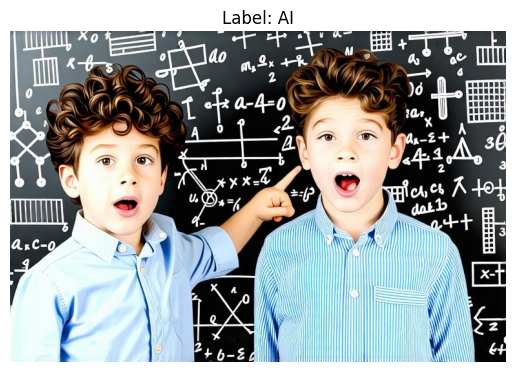

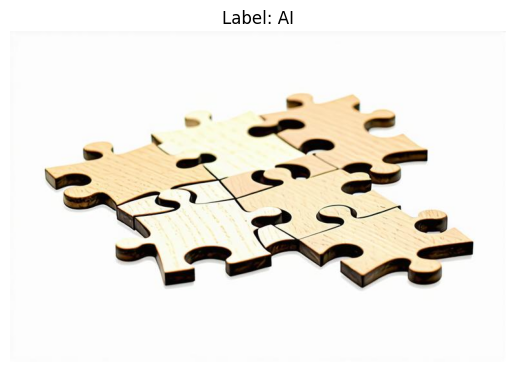

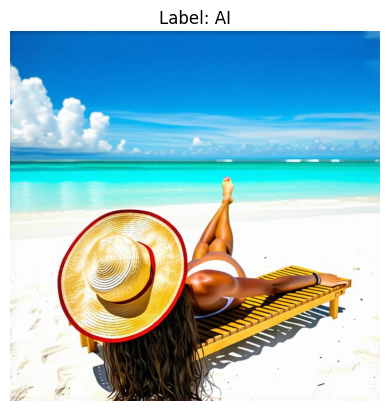

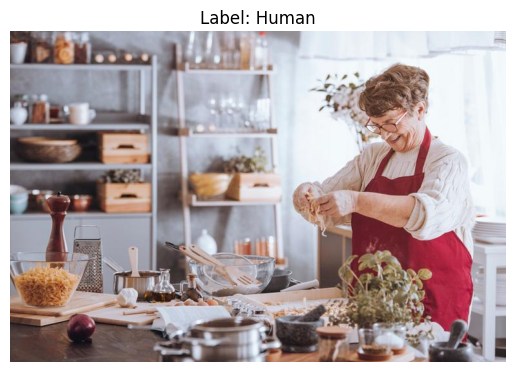

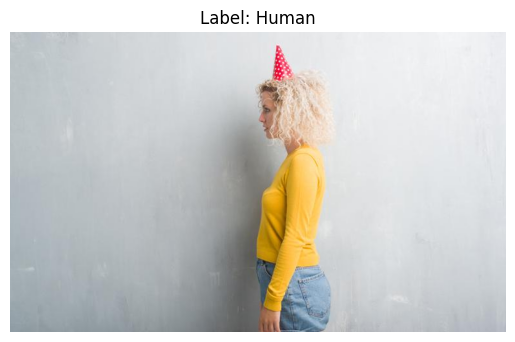

In [9]:
for idx, row in X_train.reset_index().iloc[:5].iterrows():
    img_path = os.path.join(IMAGE_BASE_DIR, row['file_name'])
    img = read_image(img_path)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Label: {"AI" if y_train.iloc[idx] else "Human"}")
    plt.show()

In [285]:
# Performs the letterbox transformation on all images
class Letterbox:
    def __init__(self, size, fill=128):
        self.size = size  # (Width, Height)
        self.fill = fill

    def __call__(self, img):
        # img is a tensor after v2.ToImage() (C,H,W)
        _, h, w = img.shape
        target_w, target_h = self.size

        # Compute scale
        scale = min(target_w / w, target_h / h)
        new_w = int(w * scale)
        new_h = int(h * scale)

        # Resize
        img = F.resize(img, (new_h, new_w), interpolation=F.InterpolationMode.BILINEAR)

        # Create padded canvas with grey background
        padded = torch.full((3, target_h, target_w), self.fill, dtype=torch.uint8, device=img.device)

        # Pastes the image into the center of the canvas
        top = (target_h - new_h) // 2
        left = (target_w - new_w) // 2
        padded[:, top:top+new_h, left:left+new_w] = img

        return padded

In [286]:
TARGET_SIZE = (224, 224)

image_transform = v2.Compose([
    v2.ToImage(),
    Letterbox(TARGET_SIZE),     
    v2.ToDtype(torch.float32, scale=True),                
])

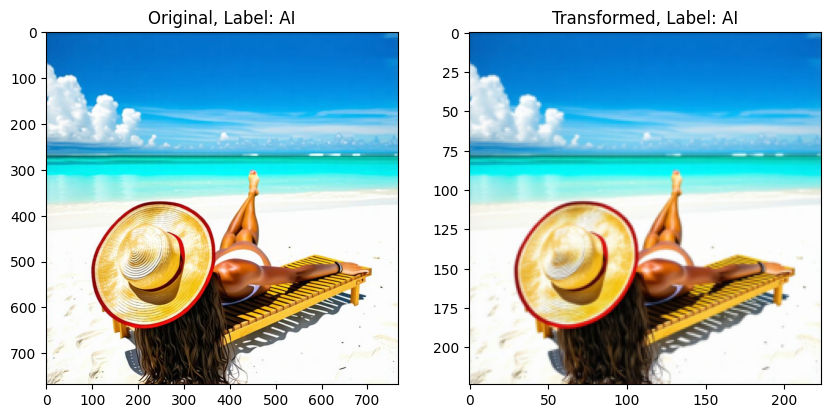

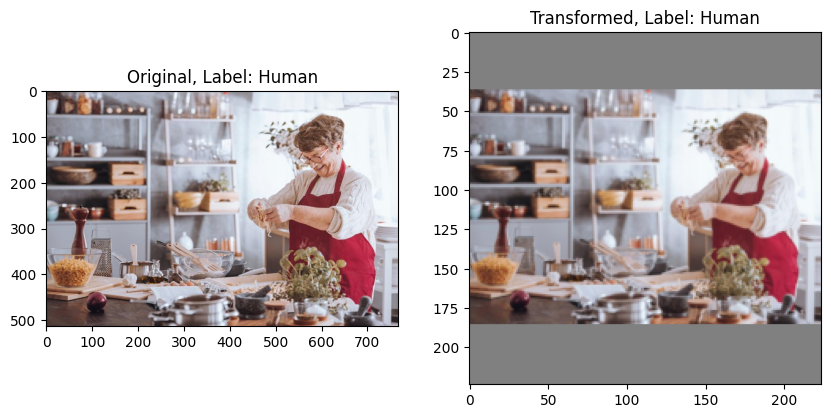

In [ ]:
for idx, row in X_train.reset_index().iloc[2:4].iterrows():
    img_path = os.path.join(IMAGE_BASE_DIR, row['file_name'])
    img = read_image(img_path)
    transformed_img = image_transform(img)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img.permute(1,2,0))
    #axes[0].axis('off')
    axes[0].set_title(f"Original, Label: {"AI" if y_train.iloc[idx] else "Human"}")

    axes[1].imshow(transformed_img.permute(1,2,0))
    #axes[1].axis('off')
    axes[1].set_title(f"Transformed, Label: {"AI" if y_train.iloc[idx] else "Human"}")

    plt.show()

In [288]:
class AIImageDataset(Dataset):
    def __init__(self, X, y, root_dir, transform=None):
        self.X = X
        self.y = y
        self.root = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        file_name = self.X.iloc[idx]['file_name']
        img_path = f"{self.root}/{file_name}"

        img = read_image(img_path)

        if self.transform:
            img = self.transform(img)

        label = int(self.y.iloc[idx])
        return img, label

In [289]:
train_image_dataset = AIImageDataset(
    X = X_train,
    y = y_train,
    root_dir=IMAGE_BASE_DIR,
    transform=image_transform
)
train_image_loader = DataLoader(train_image_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)

test_image_dataset = AIImageDataset(
    X = X_test,
    y = y_test,
    root_dir=IMAGE_BASE_DIR,
    transform=image_transform
)

test_image_loader = DataLoader(test_image_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

In [290]:
assert torch.cuda.is_available()

In [291]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_pool_stack = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # 224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 112
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 56
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        logits = self.conv_pool_stack(x)
        return logits
    
ConvNeuralNetwork()

ConvNeuralNetwork(
  (conv_pool_stack): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=100352, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [292]:
PREDICTION_THRESHOLD = 0.5

In [293]:
def train_image_model(data_loader, epochs=5, lr=1e-3):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = ConvNeuralNetwork()

    model = model.to(device, non_blocking=True)

    loss_fn = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    accuracies = []
    for i in range(epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        epoch_start = time.time()
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(X_batch)
            logits = logits.squeeze(1)
            y_batch = y_batch.float()

            probs = torch.sigmoid(logits)
            preds = (probs >= PREDICTION_THRESHOLD).long()

            acc = (preds == y_batch).float().mean().item()
            running_acc += acc

            loss = loss_fn(logits, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(data_loader)
        losses.append(epoch_loss)
        epoch_acc = running_acc / len(data_loader)
        accuracies.append(epoch_acc)
        epoch_end = time.time()
        epoch_runtime = epoch_end - epoch_start
        print(f"Epoch {i} Accuracy: {epoch_acc:.2%}, Runtime: {epoch_runtime:.4f}s")

    return model, losses, accuracies

In [294]:
image_model, image_losses, image_accuracies = train_image_model(train_image_loader, epochs=10)

Epoch 0 Accuracy: 86.78%, Runtime: 147.8248s
Epoch 1 Accuracy: 91.60%, Runtime: 159.6960s
Epoch 2 Accuracy: 93.01%, Runtime: 187.4418s
Epoch 3 Accuracy: 94.19%, Runtime: 151.6658s
Epoch 4 Accuracy: 95.56%, Runtime: 150.9015s
Epoch 5 Accuracy: 96.50%, Runtime: 163.7965s
Epoch 6 Accuracy: 97.57%, Runtime: 143.9206s
Epoch 7 Accuracy: 98.11%, Runtime: 145.0831s
Epoch 8 Accuracy: 98.68%, Runtime: 144.6287s
Epoch 9 Accuracy: 98.99%, Runtime: 145.8735s


In [295]:
device = "cuda" if torch.cuda.is_available() else "cpu"
results = {}

# Evaluate test accuracy
with torch.no_grad():
    running_acc = 0.0
    for X_batch, y_batch in test_image_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = image_model(X_batch)
        logits = logits.squeeze(1)

        probs = torch.sigmoid(logits)
        preds = (probs >= PREDICTION_THRESHOLD).long()

        acc = (preds == y_batch).float().mean().item()
        running_acc += acc
    test_acc = running_acc / len(test_image_loader)

results['CNN'] = {'losses': image_losses, 'accuracies': image_accuracies, 'test_acc': test_acc}
print(f"Image CNN Test Accuracy: {test_acc:.2%}")

Image CNN Test Accuracy: 90.13%


In [296]:
all_probs = []
all_preds = []
all_labels = []
all_indices = []

with torch.no_grad():
    for batch_idx, (imgs, labels) in enumerate(test_image_loader):
        logits = image_model(imgs.to(device))
        logits = logits.squeeze(1)
        
        probs = torch.sigmoid(logits.cpu())
        preds = (probs >= PREDICTION_THRESHOLD).long()

        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.cpu())

        # compute the global indices for the dataset
        start = batch_idx * test_image_loader.batch_size
        end = start + len(labels)
        batch_indices = torch.arange(start, end)
        all_indices.append(batch_indices)

all_probs = torch.cat(all_probs)
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
all_indices = torch.cat(all_indices)

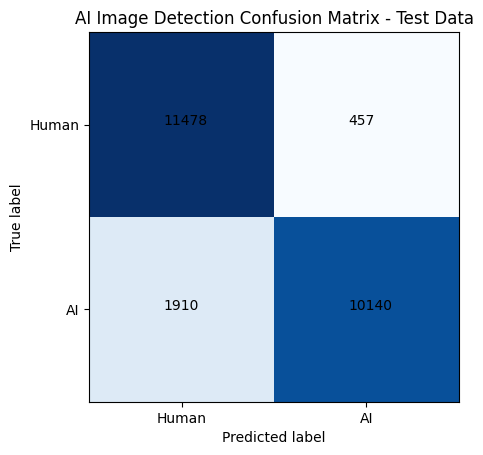

In [297]:
cm = confusion_matrix(all_labels, all_preds)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Human', 'AI']
plt.title('AI Image Detection Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)

for i in range(2):
    for j in range(2):
        plt.text(j-0.1, i, str(cm[i][j]))
plt.show()

In [298]:
error_scores = torch.abs(all_probs - all_labels)
wrong_mask = all_preds != all_labels

wrong_conf = error_scores[wrong_mask]
wrong_idxs = all_indices[wrong_mask]
wrong_idxs.size()

torch.Size([2367])

In [299]:
k = 5
sorted_conf, sorted_idx = torch.sort(wrong_conf, descending=True)
worst_k = wrong_idxs[sorted_idx][:k].tolist()   # K = top mistakes

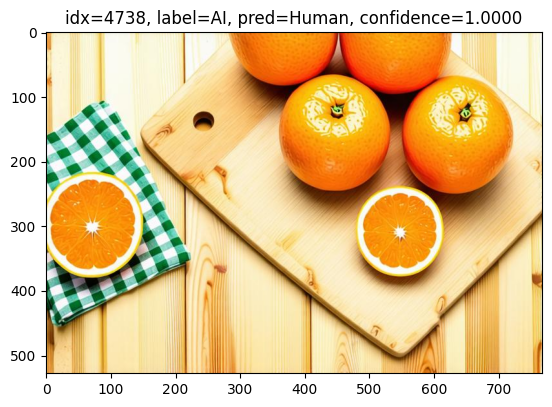

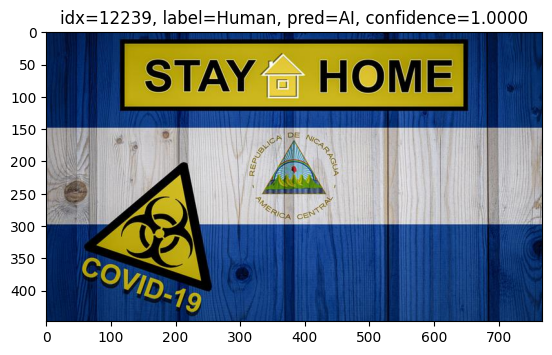

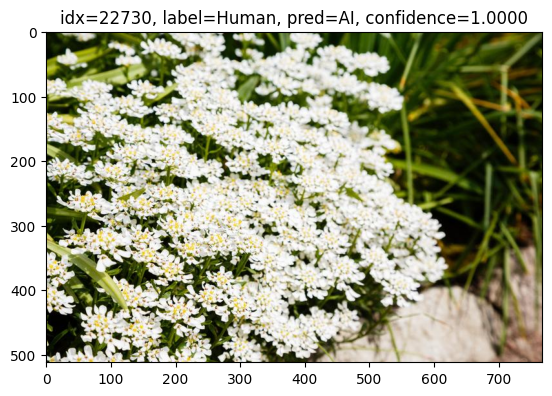

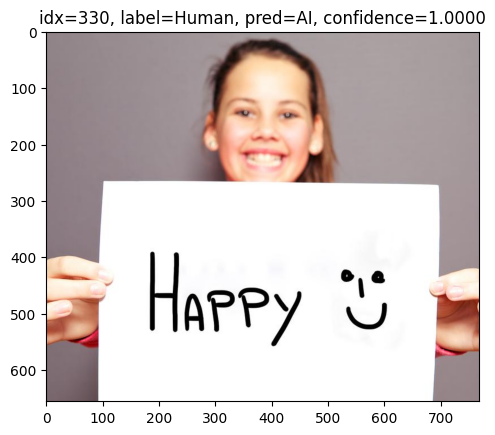

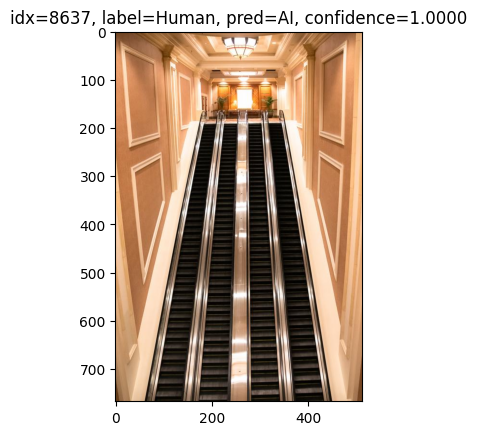

In [ ]:
for idx in worst_k:
    file_name = X_test.iloc[idx]['file_name']
    img_path = os.path.join(IMAGE_BASE_DIR, file_name)
    img = read_image(img_path)

    label = y_test.iloc[idx]

    pred = all_preds[idx].item()
    conf = error_scores[idx].item()

    plt.title(f"idx={idx}, label={'AI' if label else 'Human'}, pred={'AI' if pred else 'Human'}, confidence={conf:.4f}")
    plt.imshow(img.permute(1,2,0))
    plt.show()

C:\Users\brend\AppData\Local\Temp\ipykernel_22852\1362957787.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


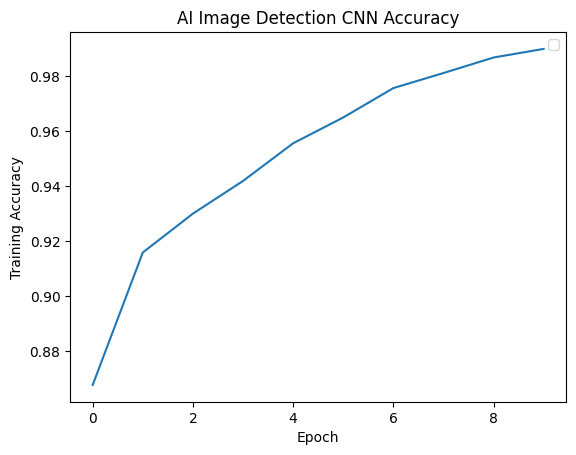

In [301]:
for opt, opt_result in results.items():
    plt.plot(opt_result['accuracies'])
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("AI Image Detection CNN Accuracy")
plt.legend()
plt.show()

C:\Users\brend\AppData\Local\Temp\ipykernel_22852\1437401228.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


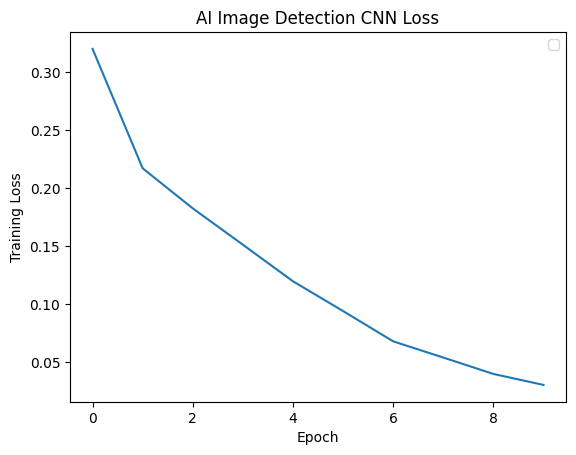

In [302]:
for opt, opt_result in results.items():
    plt.plot(opt_result['losses'])
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("AI Image Detection CNN Loss")
plt.legend()
plt.show()